In [1]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff
using Optim

In [2]:
Random.seed!(1234)

function toy_PoissonLDS()
    T = 100
    # create a PLDS model
    x0 = [1.0, -1.0]
    p0 = Matrix(Diagonal([0.1, 0.1]))
    A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
    Q = Matrix(Diagonal([0.1, 0.1]))
    C = [0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2
    log_d = log.([0.1, 0.1, 0.1])
    D = Matrix(Diagonal([0., 0., 0.]))
    b = ones(T, 2) * 0.00

    plds = PoissonLDS(A=A, C=C, Q=Q, D=D, b=b, log_d=log_d, x0=x0, p0=p0, refractory_period=1, obs_dim=3, latent_dim=2)
    # sample data
    x, y = SSM.sample(plds, T, 1)
    return plds, x, y
end

plds, x, y_array = toy_PoissonLDS()
plds.fit_bool = [true, true, true, true, true, true]

# plds_test = PoissonLDS(;obs_dim=3, latent_dim=2, fit_bool=[true, true, true, true, true, true, true])
# plds_test.D = [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

# b = ones(100, 2) * 0.000;
# plds.A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
# plds.Q = Matrix(Diagonal([0.00001, 0.00001]))
# plds.x0 = [1.0, -1.0]
# plds.p0 = Matrix{Float64}([0.00001 0; 0 0.00001])
# C = [0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2
# log_d = log.([0.1, 0.1, 0.1])
# D = Matrix(Diagonal([0., 0., 0.]))

6-element Vector{Bool}:
 1
 1
 1
 1
 1
 1

In [10]:
test_plds = PoissonLDS(;obs_dim=3, latent_dim=2, fit_bool=[true, true, true, true, true, true, true])
test_plds.Q = [1.0 0.0; 0.0 1.0]
test_plds.p0 = [1.0 0.0; 0.0 1.0]

lls = SSM.fit!(test_plds, y_array, 100)

Fitting PoissonLDS via LaPlace EM: 100%|████████████████| Time: 0:01:12


Maximum iterations reached without convergence.


100-element Vector{Any}:
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
   ⋮
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf

In [11]:
test_plds

PoissonLDS([-8.838545619641232 7.315950265316483; -11.365477273247263 9.42480584724997], [0.039670337049047134 0.0573683809225904; 0.011593189995181385 0.0965517428491162; 0.0914165247947477 0.03598458960682588], [1.654891085988245e8 2.1835486030626255e8; 2.1835486030626255e8 2.8814744933910394e8], [-0.46332485335381934 0.0 0.0; 0.0 -0.46332485335381934 0.0; 0.0 0.0 -0.46332485335381934], [0.5771926416104781, 0.4790789471496629, 0.5594682168694659], [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [-3.079363247704935, -10.208519056732852], [0.2891134017996553 -0.13057497322614608; -0.13057497322614608 0.26451527167142785], 1, 3, 2, Bool[1, 1, 1, 1, 1, 1, 1])

In [14]:
E_z, E_zz, E_zz_prev, x_smooth, p_smooth = SSM.E_Step(plds, y_array)

([1.2360299440959641 1.425730242368202 … -3.392267544526524 -3.2375321826391716;;; -0.9169793149713976 -0.832327763437845 … -1.3905347417548386 -1.723283199493417], [1.5869517132334614 2.127562174190035 … 13.097468291485917 12.177378025815838;;; -1.162930382540079 -1.255287445473524 … 4.629383674428906 5.565828936287786;;;; -1.162930382540079 -1.255287445473524 … 4.629383674428906 5.565828936287787;;; 0.9049517266173348 0.7939402574848147 … 2.7618542235848067 3.8860244009812304], [0.0 1.805002999702375 … 13.390766226451602 12.571318007312579;;; 0.0 -1.062947136341152 … 4.870541963860273 5.9152707395638915;;;; 0.0 -1.3472430569142668 … 3.3057205249054653 4.331169426995685;;; 0.0 0.8119046101386865 … 2.1853148067056436 3.2108623772346503], [1.2360299440959641 1.425730242368202 … -3.392267544526524 -3.2375321826391716;;; -0.9169793149713976 -0.832327763437845 … -1.3905347417548386 -1.723283199493417], [0.059181690531589115 0.09485545018674334 … 1.5899891978379073 1.6957633921914785;;; -0.

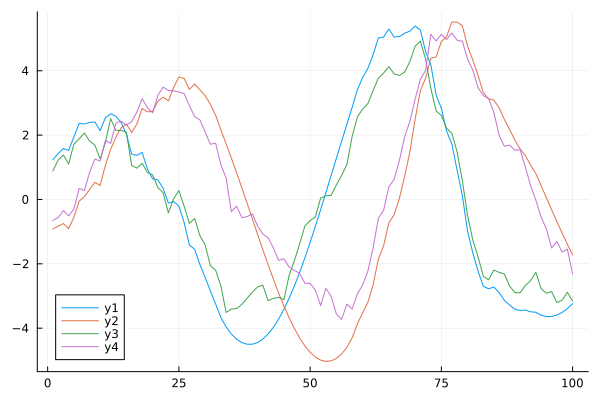

In [15]:
plot(E_z[1, :, :])
plot!(x[1, :, :])

In [148]:
decentered_nn = zeros(99, 2, 2)
for t in 2:100
    decentered_nn[t-1, :, :] = E_zz_prev[1, t, :, :] - E_z[1, t, :] * E_z[1, t-1, :]'
end

In [149]:
for i in 2:100
    decentered_nn[i-1, :, :] = decentered_nn[i-1, :, :] + E_z[1, i-1, :] * E_z[1, i, :]'
end


1×2×2 Array{Float64, 3}:
[:, :, 1] =
 97.4689  -13.3347

[:, :, 2] =
 5.76572  93.263

In [195]:
S00 = sum(E_zz[1, 1:end-1, :, :], dims=1)[1, :, :] 

2×2 Matrix{Float64}:
 97.5866   -3.97581
 -3.97581  94.1516

In [196]:
S11 = sum(E_zz[1, 2:end, :, :], dims=1)[1, :, :]

2×2 Matrix{Float64}:
 98.2851   -3.55593
 -3.55593  93.3505

In [197]:
S01 = sum(E_zz_prev[1, :, :, :], dims=1)[1, :, :]

2×2 Matrix{Float64}:
 97.4689   -13.328
  5.75902   93.263

In [200]:
q_theoretical = (S11 - (plds.A * S01') - (S01 * plds.A) + (plds.A * S00 * plds.A')) ./ 100

2×2 Matrix{Float64}:
  0.0266349  0.194613
 -0.186215   0.0115222

In [151]:
sum(decentered_nn, dims=1)[1, :, :]' / sum(E_zz[1, 1:end-1, :, :], dims=1)[1, :, :] 

2×2 Matrix{Float64}:
 0.994734   -0.0996245
 0.0996113   0.994768

In [87]:
p_sm_copy = dropdims(p_smooth, dims=1)
# reshape dims so we can turn into 2xT x 2 matrix
p_sm_copy = permutedims(p_sm_copy, [3, 1, 2])
p_sm_copy = reshape(p_sm_copy, (200, 2))
# export this to csv so i can import to matlab
CSV.write("p_smooth.csv", DataFrame(p_sm_copy, :auto), writeheader=false)

"p_smooth.csv"

In [143]:
# calculate the de-centered nearest-neighbor potentials
decentered_nn = zeros(99, 2, 2)
for t in 2:100
    decentered_nn[t-1, :, :] = E_zz_prev[1, t, :, :] - E_z[1, t, :] * E_z[1, t-1, :]'
end

# # reshape dims so we can turn into 2xT x 2 matrix
# decentered_nn = permutedims(decentered_nn, [3, 1, 2])
# decentered_nn = reshape(decentered_nn, (198, 2))
# # export this to csv so i can import to matlab
# CSV.write("decentered_nn.csv", DataFrame(decentered_nn, :auto), writeheader=false)


"decentered_nn.csv"

In [167]:
# optimize A 
obj = A -> -SSM.Q_state_model(A, plds.Q, E_zz, E_zz_prev)
result = optimize(obj, rand(2, 2), LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     2.319677e+07

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.09e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    303
    f(x) calls:    1013
    ∇f(x) calls:   1013


In [168]:
result.minimizer

2×2 Matrix{Float64}:
 0.994737   -0.0995533
 0.0995426   0.994766

In [10]:
lls = fit!(plds, y_array, 100)

Fitting PoissonLDS via LaPlace EM: 100%|████████████████| Time: 0:00:23


Maximum iterations reached without convergence.


100-element Vector{Any}:
 -7693.744224695171
 -5289.578218738889
 -5268.214751549502
 -5319.725068345077
 -5370.352745061279
 -5415.294674943116
 -5454.838180087475
 -5489.620841632328
 -5520.236709460202
 -5547.2093955865985
     ⋮
 -5754.582804412995
 -5754.38182841539
 -5754.179886838927
 -5753.977003840143
 -5753.7734062390855
 -5753.569091569213
 -5753.36412078839
 -5753.158571054708
 -5752.9524758164835

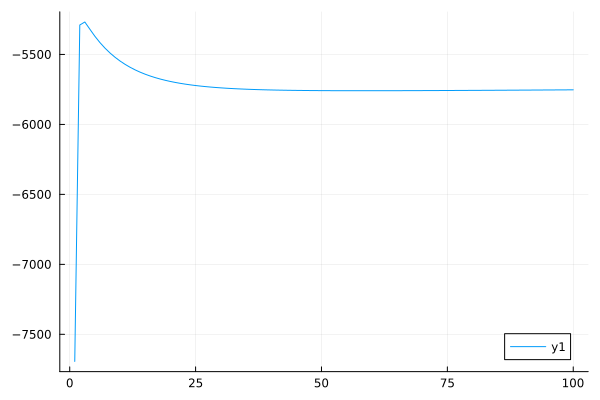

In [11]:
plot(lls)

In [5]:
plds.A

2×2 Matrix{Float64}:
 0.994734   -0.0996245
 0.0996113   0.994768

In [208]:
sum(E_zz_prev[1, :, :, :], dims=1)[1, :, :]' \ sum(E_zz[1, 1:end-1, :, :], dims=1)[1, :, :] 

2×2 Matrix{Float64}:
 0.995041   -0.099732
 0.0997319   0.99504

In [37]:
using CSV
using DataFrames

xsm_matlab = CSV.read("/Users/ryansenne/Documents/GitHub/pop_spike_dyn/xsm.csv", DataFrame; header=false)
xsm_matlab = Matrix(permutedims(xsm_matlab))

100×2 Matrix{Float64}:
  0.999478  -0.999931
  1.09376   -0.895173
  1.1771    -0.781591
  1.24869   -0.660321
  1.30786   -0.532542
  1.35402   -0.399513
  1.38669   -0.262582
  1.4056    -0.123066
  1.41053    0.0176232
  1.40137    0.158021
  ⋮         
 -0.588822   1.24422
 -0.709942   1.17933
 -0.824003   1.10267
 -0.92992    1.01493
 -1.02657    0.917049
 -1.11297    0.809993
 -1.18825    0.694864
 -1.25169    0.572757
 -1.30261    0.444945

In [48]:
E_z, E_zz, E_zz_prev, x_smooth, p_smooth = SSM.E_Step(plds, y_array)

([1.000846168363414 1.0933444803032262 … -1.0903731969381003 -1.1513887541409826;;; -1.000369705788781 -0.8962378121677432 … 0.6846066496076454 0.5735388169355287], [1.001697996697312 1.1954167157972082 … 1.1895331693309827 1.3263123072083316;;; -1.001215461153142 -0.9798959386173792 … -0.7464139964854534 -0.6603055936192129;;;; -1.001215461153142 -0.9798959386173792 … -0.7464139964854534 -0.6603055936192129;;; 1.0007447950472783 0.8032573941051162 … 0.4693143802638349 0.3295956112835786], [0.0 1.094274423187649 … 1.1113274342805104 1.2560532181927382;;; 0.0 -0.8969959601127522 … -0.6973754310350406 -0.6253706212698503;;;; 0.0 -1.0937474865397563 … -0.8604898412715912 -0.7881252549797182;;; 0.0 0.8965743928740547 … 0.5409581421432706 0.39327900866979026], [1.000846168363414 1.0933444803032262 … -1.0903731969381003 -1.1513887541409826;;; -1.000369705788781 -0.8962378121677432 … 0.6846066496076454 0.5735388169355287], [4.943969584769862e-6 1.4563187676489381e-5 … 0.0006194607299694901 0.

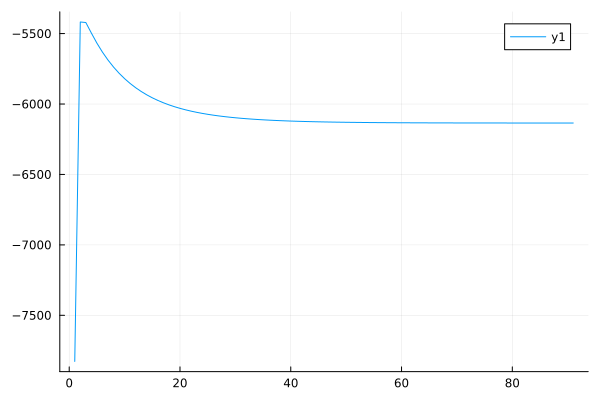

In [46]:
plot(lls)

In [49]:
x_sm, p_sm = SSM.smooth(plds, y_array)

([1.000846168363414 1.0933444803032262 … -1.0903731969381003 -1.1513887541409826;;; -1.000369705788781 -0.8962378121677432 … 0.6846066496076454 0.5735388169355287], [4.943969584769862e-6 1.4563187676489381e-5 … 0.0006194607299694901 0.000616244046007281;;; 7.258323952376292e-7 7.263552623865963e-7 … 6.274469231676813e-5 6.055026367855494e-5;;;; 7.258323952376281e-7 7.263552623865973e-7 … 6.274469231677046e-5 6.0550263678556347e-5;;; 5.246787345830728e-6 1.5178145893223183e-5 … 0.0006281155768295311 0.0006488367517727459], [0.0 4.7893748769069285e-6 … 0.0006132257777088908 0.000609781421458575;;; 0.0 1.2095469697852843e-6 … 0.00012331071154389264 0.0001231423886608438;;;; 0.0 2.2013774277326826e-7 … 2.618141160923019e-6 7.321202378281769e-7;;; 0.0 5.236399028602724e-6 … 0.0006096740756931483 0.0006305207876253102])

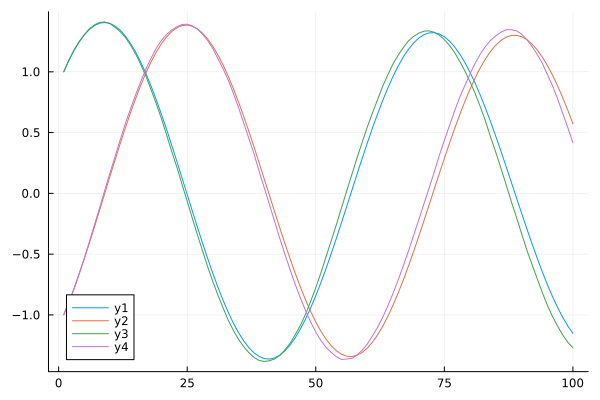

In [50]:
plot(x_sm[1, :, 1])
plot!(x_sm[1, :, 2])

plot!(x[1, :, 1])
plot!(x[1, :, 2])

In [39]:
plds.C

3×2 Matrix{Float64}:
 1.12113  1.15694
 1.12472  1.26127
 1.16956  1.08908

In [35]:
exp.(plds.log_d)

3-element Vector{Float64}:
 0.17333494521317422
 0.07484924350700586
 0.2533437355947315

In [3]:
E_z, E_zz, E_zz_prev = SSM.E_Step(plds, y_array)

([0.9999759103041774 1.0946199139845638 … -1.2919394252529257 -1.3421551856731675; 1.0001940763887724 1.095320587003854 … -1.3021748106239206 -1.354774594554899; 1.000355936493323 1.0955150091075676 … -1.3040614149771796 -1.3518418745155194;;; -0.9992942167931805 -0.893806277366088 … 0.5676322552938096 0.435816322625079; -1.0005216602079898 -0.8961791161210368 … 0.5920227428982117 0.4590629537992017; -0.9999358305100126 -0.8949940910133938 … 0.5437304920288352 0.4108123357023224], [0.9999616992039223 1.1982122441597851 … 1.6697318578356521 1.8020012911611631; 1.0003980672030794 1.1997466707735334 … 1.6962794957989376 1.836030391334739; 1.000721876451097 1.200172617892513 … 1.701198466755393 1.8280954220588883;;; -0.9992701118984886 -0.9783780274265854 … -0.7332750682037011 -0.5848689490559282; -1.00071580495286 -0.9816033094059491 … -0.7708435791807552 -0.621860373007908; -1.0002917114403094 -0.9804793349575301 … -0.7089878084676622 -0.5552908955386409;;;; -0.9992701118984886 -0.978378

In [10]:
function Q_observation_model(C::Matrix{<:Real}, D::Matrix{<:Real}, log_d::Vector{<:Real}, E_z::Array{<:Real}, E_zz::Array{<:Real}, y::Array{<:Real})
    # Re-parametrize log_d
    d = exp.(log_d)
    # Compute Q
    Q_val = 0.0
    trials = size(E_z, 1)
    time_steps = size(E_z, 2)
    # sum over trials
    for k in 1:trials
        spikes = SSM.countspikes(y[k, :, :])
        # sum over time-points
        for t in 1:time_steps
            # linear term
            term_1 = y[k, t, :]' * (C * E_z[k, t, :] + D*spikes[t, :] + d)
            # first part of quadratic term (sum over neurons)
            term_2 = sum(exp.(C * E_z[k, t, :] + D*spikes[t, :] + d))
            # second part of quadratic term (sum over neurons)
            term_3 = 0.0
            for i in axes(C, 1)
                term_3 += 0.5 * C[i, :]' * E_zz[k, t, :, :] * C[i, :]
            end
            Q_val += term_1 - term_2 + term_3
        end
    end
    return Q_val
end

function obj_func(params::Vector{<:Real}, D::Matrix{<:Real}, E_z::Array{<:Real}, E_zz::Array{<:Real}, y::Array{<:Real})
    # Split params into C and log_d
    C_size = size(D, 1)  # Assuming C has the same number of rows as D
    log_d = params[end-size(D, 2)+1:end]  # Assuming log_d has the same length as the number of columns in D
    C = reshape(params[1:end-size(D, 2)], C_size, :)  # Reshape the remaining params into C

    # Call Q_observation_model with the new C and log_d, and other unchanged parameters
    Q_val = Q_observation_model(C, D, log_d, E_z, E_zz, y)

    return -Q_val
end

# make objective function that optimizes all parameters now
function obj_func_with_D(params::Vector{<:Real}, E_z::Array{<:Real}, E_zz::Array{<:Real}, y::Array{<:Real})
    # split up parameters from params
    C_dims = plds.obs_dim * plds.latent_dim
    D_dims = plds.obs_dim * plds.obs_dim
    log_d_dims = plds.obs_dim
    # extract params
    C = reshape(params[1:C_dims], plds.obs_dim, plds.latent_dim)
    println(C)
    D = reshape(params[C_dims+1:C_dims+D_dims], plds.obs_dim, plds.obs_dim)
    println(D)
    log_d = params[C_dims+D_dims+1:end]
    println(log_d)
    # Call Q_observation_model with the new C and log_d, and other unchanged parameters
    Q_val = Q_observation_model(C, D, log_d, E_z, E_zz, y)
    return -Q_val
end
    

res = optimize(params -> obj_func(params, plds.D, E_z, E_zz, y_array), zeros(9), LBFGS(), autodiff=:forward, Optim.Options(show_trace=true))
# res = optimize(params -> obj_func_with_D(params, E_z, E_zz, y_array), zeros(18), LBFGS(), autodiff=:forward, Optim.Options(show_trace=true))


Iter     Function value   Gradient norm 
     0    -1.341546e+03     8.899764e+02
 * time: 0.0
     1    -3.183300e+03     3.623304e+02
 * time: 0.04999995231628418
     2    -3.779199e+03     6.966445e+02
 * time: 0.04999995231628418
     3    -4.400740e+03     4.518906e+02
 * time: 0.06299996376037598
     4    -4.551291e+03     4.954996e+02
 * time: 0.06699991226196289
     5    -4.947962e+03     1.870401e+02
 * time: 0.11500000953674316
     6    -5.056604e+03     2.151283e+02
 * time: 0.12299990653991699
     7    -5.125442e+03     1.437149e+02
 * time: 0.12899994850158691
     8    -5.176298e+03     1.367790e+02
 * time: 0.1380000114440918
     9    -5.197151e+03     1.149796e+02
 * time: 0.1419999599456787
    10    -5.216567e+03     5.794343e+01
 * time: 0.14999985694885254
    11    -5.224304e+03     3.842986e+01
 * time: 0.15700006484985352
    12    -5.228330e+03     3.141597e+01
 * time: 0.17599987983703613
    13    -5.229582e+03     1.006938e+01
 * time: 0.197999954223632

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     -5.230506e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.96e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.44e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.64e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.96e-16 ≰ 0.0e+00
    |g(x)|                 = 5.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    65
    f(x) calls:    202
    ∇f(x) calls:   202


In [11]:
obj_func_with_D(zeros(18), E_z, E_zz, y_array)

[0.0 0.0; 0.0 0.0; 0.0 0.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
[0.0, 0.0, 0.0]


-1341.5463543868655

In [9]:
res.minimizer

9-element Vector{Float64}:
   1.4432421461844631
   1.4921364187523414
   1.5315551819843456
   1.4408567908558414
   1.45082045049293
   1.3813205298894544
 -49.558602529054745
 -55.467134099555714
 -51.38758778714786

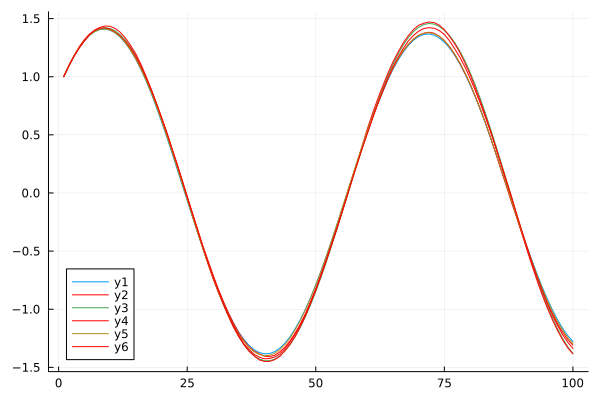

In [76]:
plot(E_z[1, :, 1])
plot!(x[1, :, 1], color="red")
plot!(E_z[2, :, 1])
plot!(x[2, :, 1], color="red")
plot!(E_z[3, :, 1])
plot!(x[3, :, 1], color="red")

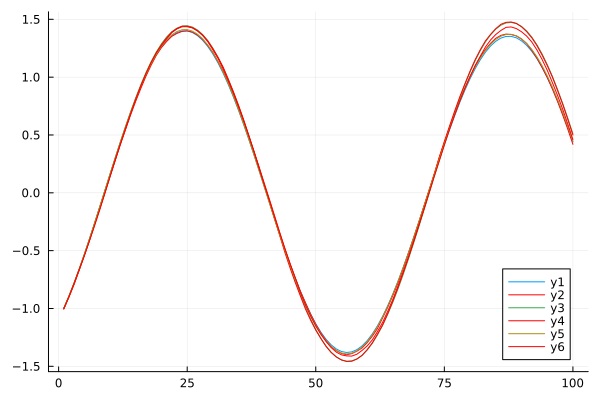

In [77]:
plot(E_z[1, :, 2])
plot!(x[1, :, 2], color="red")
plot!(E_z[2, :, 2])
plot!(x[2, :, 2], color="red")
plot!(E_z[3, :, 2])
plot!(x[3, :, 2], color="red")

In [13]:
ll = fit!(plds, y_array, 100)

Succesfully smoothed at iteration 1
Succesfully updated parameters at iteration 1


Fitting PoissonLDS via LaPlace EM:   2%|█               |  ETA: 0:00:17

Succesfully smoothed at iteration 2
Succesfully updated parameters at iteration 2


Fitting PoissonLDS via LaPlace EM:   3%|█               |  ETA: 0:00:17

Succesfully smoothed at iteration 3
Succesfully updated parameters at iteration 3


Fitting PoissonLDS via LaPlace EM:   4%|█               |  ETA: 0:00:17

Succesfully smoothed at iteration 4
Succesfully updated parameters at iteration 4


Fitting PoissonLDS via LaPlace EM:   5%|█               |  ETA: 0:00:16

Succesfully smoothed at iteration 5
Succesfully updated parameters at iteration 5


Fitting PoissonLDS via LaPlace EM:   6%|█               |  ETA: 0:00:16

Succesfully smoothed at iteration 6
Succesfully updated parameters at iteration 6


Fitting PoissonLDS via LaPlace EM:   7%|██              |  ETA: 0:00:16

Succesfully smoothed at iteration 7
Succesfully updated parameters at iteration 7


Fitting PoissonLDS via LaPlace EM:   8%|██              |  ETA: 0:00:16

Succesfully smoothed at iteration 8
Succesfully updated parameters at iteration 8


Fitting PoissonLDS via LaPlace EM:   9%|██              |  ETA: 0:00:16

Succesfully smoothed at iteration 9
Succesfully updated parameters at iteration 9


Fitting PoissonLDS via LaPlace EM:  10%|██              |  ETA: 0:00:16

Succesfully smoothed at iteration 10
Succesfully updated parameters at iteration 10


Fitting PoissonLDS via LaPlace EM:  11%|██              |  ETA: 0:00:15

Succesfully smoothed at iteration 11
Succesfully updated parameters at iteration 11


Fitting PoissonLDS via LaPlace EM:  12%|██              |  ETA: 0:00:15

Succesfully smoothed at iteration 12
Succesfully updated parameters at iteration 12


Fitting PoissonLDS via LaPlace EM:  13%|███             |  ETA: 0:00:15

Succesfully smoothed at iteration 13
Succesfully updated parameters at iteration 13


Fitting PoissonLDS via LaPlace EM:  14%|███             |  ETA: 0:00:15

Succesfully smoothed at iteration 14
Succesfully updated parameters at iteration 14


Fitting PoissonLDS via LaPlace EM:  15%|███             |  ETA: 0:00:15

Succesfully smoothed at iteration 15
Succesfully updated parameters at iteration 15


Fitting PoissonLDS via LaPlace EM:  16%|███             |  ETA: 0:00:15

Succesfully smoothed at iteration 16
Succesfully updated parameters at iteration 16


Fitting PoissonLDS via LaPlace EM:  17%|███             |  ETA: 0:00:15

Succesfully smoothed at iteration 17
Succesfully updated parameters at iteration 17


Fitting PoissonLDS via LaPlace EM:  18%|███             |  ETA: 0:00:15

Succesfully smoothed at iteration 18
Succesfully updated parameters at iteration 18


Fitting PoissonLDS via LaPlace EM:  19%|████            |  ETA: 0:00:15

Succesfully smoothed at iteration 19
Succesfully updated parameters at iteration 19


Fitting PoissonLDS via LaPlace EM:  20%|████            |  ETA: 0:00:15

Succesfully smoothed at iteration 20
Succesfully updated parameters at iteration 20


Fitting PoissonLDS via LaPlace EM:  21%|████            |  ETA: 0:00:15

Succesfully smoothed at iteration 21
Succesfully updated parameters at iteration 21


Fitting PoissonLDS via LaPlace EM:  22%|████            |  ETA: 0:00:14

Succesfully smoothed at iteration 22
Succesfully updated parameters at iteration 22


Fitting PoissonLDS via LaPlace EM:  23%|████            |  ETA: 0:00:14

Succesfully smoothed at iteration 23
Succesfully updated parameters at iteration 23


Fitting PoissonLDS via LaPlace EM:  24%|████            |  ETA: 0:00:14

Succesfully smoothed at iteration 24
Succesfully updated parameters at iteration 24


Fitting PoissonLDS via LaPlace EM:  25%|█████           |  ETA: 0:00:14

Succesfully smoothed at iteration 25
Succesfully updated parameters at iteration 25
Succesfully smoothed at iteration 26


Fitting PoissonLDS via LaPlace EM:  26%|█████           |  ETA: 0:00:14

Succesfully updated parameters at iteration 26


Fitting PoissonLDS via LaPlace EM:  27%|█████           |  ETA: 0:00:13

Succesfully smoothed at iteration 27
Succesfully updated parameters at iteration 27


Fitting PoissonLDS via LaPlace EM:  28%|█████           |  ETA: 0:00:13

Succesfully smoothed at iteration 28
Succesfully updated parameters at iteration 28


Fitting PoissonLDS via LaPlace EM:  29%|█████           |  ETA: 0:00:13

Succesfully smoothed at iteration 29
Succesfully updated parameters at iteration 29


Fitting PoissonLDS via LaPlace EM:  30%|█████           |  ETA: 0:00:13

Succesfully smoothed at iteration 30
Succesfully updated parameters at iteration 30


Fitting PoissonLDS via LaPlace EM:  31%|█████           |  ETA: 0:00:13

Succesfully smoothed at iteration 31
Succesfully updated parameters at iteration 31


Fitting PoissonLDS via LaPlace EM:  32%|██████          |  ETA: 0:00:13

Succesfully smoothed at iteration 32
Succesfully updated parameters at iteration 32
Succesfully smoothed at iteration 

Fitting PoissonLDS via LaPlace EM:  33%|██████          |  ETA: 0:00:13

33
Succesfully updated parameters at iteration 33


Fitting PoissonLDS via LaPlace EM:  34%|██████          |  ETA: 0:00:12

Succesfully smoothed at iteration 34
Succesfully updated parameters at iteration 34
Succesfully smoothed at iteration 

Fitting PoissonLDS via LaPlace EM:  35%|██████          |  ETA: 0:00:12

35
Succesfully updated parameters at iteration 35
Succesfully smoothed at iteration 36


Fitting PoissonLDS via LaPlace EM:  36%|██████          |  ETA: 0:00:12

Succesfully updated parameters at iteration 36


Fitting PoissonLDS via LaPlace EM:  37%|██████          |  ETA: 0:00:12

Succesfully smoothed at iteration 37
Succesfully updated parameters at iteration 37
Succesfully smoothed at iteration 

Fitting PoissonLDS via LaPlace EM:  38%|███████         |  ETA: 0:00:12

38
Succesfully updated parameters at iteration 38


Fitting PoissonLDS via LaPlace EM:  39%|███████         |  ETA: 0:00:12

Succesfully smoothed at iteration 39
Succesfully updated parameters at iteration 39


Fitting PoissonLDS via LaPlace EM:  40%|███████         |  ETA: 0:00:12

Succesfully smoothed at iteration 40
Succesfully updated parameters at iteration 40


Fitting PoissonLDS via LaPlace EM:  41%|███████         |  ETA: 0:00:11

Succesfully smoothed at iteration 41
Succesfully updated parameters at iteration 41
Succesfully smoothed at iteration 42


Fitting PoissonLDS via LaPlace EM:  42%|███████         |  ETA: 0:00:11

Succesfully updated parameters at iteration 42


Fitting PoissonLDS via LaPlace EM:  43%|███████         |  ETA: 0:00:11

Succesfully smoothed at iteration 43
Succesfully updated parameters at iteration 43


Fitting PoissonLDS via LaPlace EM:  44%|████████        |  ETA: 0:00:11

Succesfully smoothed at iteration 44
Succesfully updated parameters at iteration 44


Fitting PoissonLDS via LaPlace EM:  45%|████████        |  ETA: 0:00:11

Succesfully smoothed at iteration 45
Succesfully updated parameters at iteration 45


Fitting PoissonLDS via LaPlace EM:  46%|████████        |  ETA: 0:00:10

Succesfully smoothed at iteration 46
Succesfully updated parameters at iteration 46


Fitting PoissonLDS via LaPlace EM:  47%|████████        |  ETA: 0:00:10

Succesfully smoothed at iteration 47
Succesfully updated parameters at iteration 47


Fitting PoissonLDS via LaPlace EM:  48%|████████        |  ETA: 0:00:10

Succesfully smoothed at iteration 48
Succesfully updated parameters at iteration 48


Fitting PoissonLDS via LaPlace EM:  49%|████████        |  ETA: 0:00:10

Succesfully smoothed at iteration 49
Succesfully updated parameters at iteration 49


Fitting PoissonLDS via LaPlace EM:  50%|█████████       |  ETA: 0:00:10

Succesfully smoothed at iteration 50
Succesfully updated parameters at iteration 50


Fitting PoissonLDS via LaPlace EM:  51%|█████████       |  ETA: 0:00:09

Succesfully smoothed at iteration 51
Succesfully updated parameters at iteration 51


Fitting PoissonLDS via LaPlace EM:  52%|█████████       |  ETA: 0:00:09

Succesfully smoothed at iteration 52
Succesfully updated parameters at iteration 52


Fitting PoissonLDS via LaPlace EM:  53%|█████████       |  ETA: 0:00:09

Succesfully smoothed at iteration 53
Succesfully updated parameters at iteration 53


Fitting PoissonLDS via LaPlace EM:  54%|█████████       |  ETA: 0:00:09

Succesfully smoothed at iteration 54
Succesfully updated parameters at iteration 54


Fitting PoissonLDS via LaPlace EM:  55%|█████████       |  ETA: 0:00:09

Succesfully smoothed at iteration 55
Succesfully updated parameters at iteration 55


Fitting PoissonLDS via LaPlace EM:  56%|█████████       |  ETA: 0:00:08

Succesfully smoothed at iteration 56
Succesfully updated parameters at iteration 56


Fitting PoissonLDS via LaPlace EM:  57%|██████████      |  ETA: 0:00:08

Succesfully smoothed at iteration 57
Succesfully updated parameters at iteration 57


Fitting PoissonLDS via LaPlace EM:  58%|██████████      |  ETA: 0:00:08

Succesfully smoothed at iteration 58
Succesfully updated parameters at iteration 58


Fitting PoissonLDS via LaPlace EM:  59%|██████████      |  ETA: 0:00:08

Succesfully smoothed at iteration 59
Succesfully updated parameters at iteration 59


Fitting PoissonLDS via LaPlace EM:  60%|██████████      |  ETA: 0:00:08

Succesfully smoothed at iteration 60
Succesfully updated parameters at iteration 60


Fitting PoissonLDS via LaPlace EM:  61%|██████████      |  ETA: 0:00:07

Succesfully smoothed at iteration 61
Succesfully updated parameters at iteration 61
Succesfully smoothed at iteration 62

Fitting PoissonLDS via LaPlace EM:  62%|██████████      |  ETA: 0:00:07


Succesfully updated parameters at iteration 62


Fitting PoissonLDS via LaPlace EM:  63%|███████████     |  ETA: 0:00:07

Succesfully smoothed at iteration 63
Succesfully updated parameters at iteration 63


Fitting PoissonLDS via LaPlace EM:  64%|███████████     |  ETA: 0:00:07

Succesfully smoothed at iteration 64
Succesfully updated parameters at iteration 64


Fitting PoissonLDS via LaPlace EM:  65%|███████████     |  ETA: 0:00:07

Succesfully smoothed at iteration 65
Succesfully updated parameters at iteration 65


Fitting PoissonLDS via LaPlace EM:  66%|███████████     |  ETA: 0:00:07

Succesfully smoothed at iteration 66
Succesfully updated parameters at iteration 66


Fitting PoissonLDS via LaPlace EM:  67%|███████████     |  ETA: 0:00:06

Succesfully smoothed at iteration 67
Succesfully updated parameters at iteration 67


Fitting PoissonLDS via LaPlace EM:  68%|███████████     |  ETA: 0:00:06

Succesfully smoothed at iteration 68
Succesfully updated parameters at iteration 68


Fitting PoissonLDS via LaPlace EM:  69%|████████████    |  ETA: 0:00:06

Succesfully smoothed at iteration 69
Succesfully updated parameters at iteration 69


Fitting PoissonLDS via LaPlace EM:  70%|████████████    |  ETA: 0:00:06

Succesfully smoothed at iteration 70
Succesfully updated parameters at iteration 70


Fitting PoissonLDS via LaPlace EM:  71%|████████████    |  ETA: 0:00:06

Succesfully smoothed at iteration 71
Succesfully updated parameters at iteration 71


Fitting PoissonLDS via LaPlace EM:  72%|████████████    |  ETA: 0:00:05

Succesfully smoothed at iteration 72
Succesfully updated parameters at iteration 72
Succesfully smoothed at iteration 73


Fitting PoissonLDS via LaPlace EM:  73%|████████████    |  ETA: 0:00:05

Succesfully updated parameters at iteration 73
Succesfully smoothed at iteration 74

Fitting PoissonLDS via LaPlace EM:  74%|████████████    |  ETA: 0:00:05


Succesfully updated parameters at iteration 74
Succesfully smoothed at iteration 75


Fitting PoissonLDS via LaPlace EM:  75%|█████████████   |  ETA: 0:00:05

Succesfully updated parameters at iteration 75


Fitting PoissonLDS via LaPlace EM:  76%|█████████████   |  ETA: 0:00:05

Succesfully smoothed at iteration 76
Succesfully updated parameters at iteration 76


Fitting PoissonLDS via LaPlace EM:  77%|█████████████   |  ETA: 0:00:05

Succesfully smoothed at iteration 77
Succesfully updated parameters at iteration 77


Fitting PoissonLDS via LaPlace EM:  78%|█████████████   |  ETA: 0:00:04

Succesfully smoothed at iteration 78
Succesfully updated parameters at iteration 78


Fitting PoissonLDS via LaPlace EM:  79%|█████████████   |  ETA: 0:00:04

Succesfully smoothed at iteration 79
Succesfully updated parameters at iteration 79


Fitting PoissonLDS via LaPlace EM:  80%|█████████████   |  ETA: 0:00:04

Succesfully smoothed at iteration 80
Succesfully updated parameters at iteration 80


Fitting PoissonLDS via LaPlace EM:  81%|█████████████   |  ETA: 0:00:04

Succesfully smoothed at iteration 81
Succesfully updated parameters at iteration 81


Fitting PoissonLDS via LaPlace EM:  82%|██████████████  |  ETA: 0:00:04

Succesfully smoothed at iteration 82
Succesfully updated parameters at iteration 82


Fitting PoissonLDS via LaPlace EM:  83%|██████████████  |  ETA: 0:00:03

Succesfully smoothed at iteration 83
Succesfully updated parameters at iteration 83


Fitting PoissonLDS via LaPlace EM:  84%|██████████████  |  ETA: 0:00:03

Succesfully smoothed at iteration 84
Succesfully updated parameters at iteration 84


Fitting PoissonLDS via LaPlace EM:  85%|██████████████  |  ETA: 0:00:03

Succesfully smoothed at iteration 85
Succesfully updated parameters at iteration 85


Fitting PoissonLDS via LaPlace EM:  86%|██████████████  |  ETA: 0:00:03

Succesfully smoothed at iteration 86
Succesfully updated parameters at iteration 86


Fitting PoissonLDS via LaPlace EM:  87%|██████████████  |  ETA: 0:00:03

Succesfully smoothed at iteration 87
Succesfully updated parameters at iteration 87


Fitting PoissonLDS via LaPlace EM:  88%|███████████████ |  ETA: 0:00:02

Succesfully smoothed at iteration 88
Succesfully updated parameters at iteration 88


Fitting PoissonLDS via LaPlace EM:  89%|███████████████ |  ETA: 0:00:02

Succesfully smoothed at iteration 89
Succesfully updated parameters at iteration 89


Fitting PoissonLDS via LaPlace EM:  90%|███████████████ |  ETA: 0:00:02

Succesfully smoothed at iteration 90
Succesfully updated parameters at iteration 90


Fitting PoissonLDS via LaPlace EM:  91%|███████████████ |  ETA: 0:00:02

Succesfully smoothed at iteration 91
Succesfully updated parameters at iteration 91
Succesfully smoothed at iteration 

Fitting PoissonLDS via LaPlace EM:  92%|███████████████ |  ETA: 0:00:02

92
Succesfully updated parameters at iteration 92


Fitting PoissonLDS via LaPlace EM:  93%|███████████████ |  ETA: 0:00:01

Succesfully smoothed at iteration 93
Succesfully updated parameters at iteration 93


Fitting PoissonLDS via LaPlace EM:  94%|████████████████|  ETA: 0:00:01

Succesfully smoothed at iteration 94
Succesfully updated parameters at iteration 94


Fitting PoissonLDS via LaPlace EM:  95%|████████████████|  ETA: 0:00:01

Succesfully smoothed at iteration 95
Succesfully updated parameters at iteration 95


Fitting PoissonLDS via LaPlace EM:  96%|████████████████|  ETA: 0:00:01

Succesfully smoothed at iteration 96
Succesfully updated parameters at iteration 96


Fitting PoissonLDS via LaPlace EM:  97%|████████████████|  ETA: 0:00:01

Succesfully smoothed at iteration 97
Succesfully updated parameters at iteration 97


Fitting PoissonLDS via LaPlace EM:  98%|████████████████|  ETA: 0:00:00

Succesfully smoothed at iteration 98
Succesfully updated parameters at iteration 98


Fitting PoissonLDS via LaPlace EM:  99%|████████████████|  ETA: 0:00:00

Succesfully smoothed at iteration 99
Succesfully updated parameters at iteration 99


Fitting PoissonLDS via LaPlace EM: 100%|████████████████| Time: 0:00:19


Succesfully smoothed at iteration 100
Succesfully updated parameters at iteration 100
Maximum iterations reached without convergence.


100-element Vector{Any}:
 6616.0496560684505
 6616.542351500811
 6617.034647785626
 6617.526545640082
 6618.0180457772585
 6618.509148910753
 6618.999855751747
 6619.490167009044
 6619.980083389604
 6620.469605598333
    ⋮
 6659.332510802697
 6659.791595578487
 6660.250339106254
 6660.708741948441
 6661.166804666356
 6661.6245278197275
 6662.081911967148
 6662.538957664934
 6662.995665469208

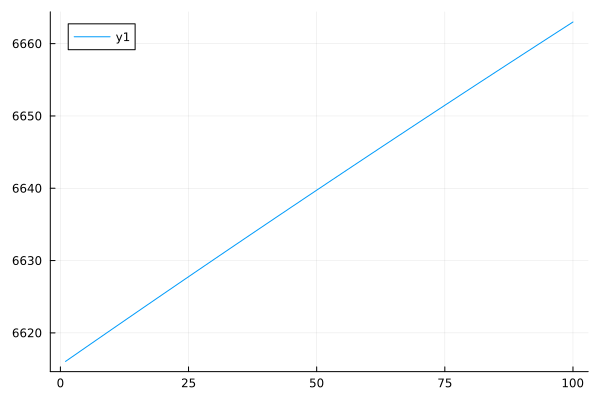

In [15]:
plot(ll)

In [14]:
plds.log_d

3-element Vector{Float64}:
 -2.3025850929940455
 -2.3025850929940455
 -2.3025850929940455

In [10]:
[0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2

3×2 Matrix{Float64}:
 1.2  1.2
 1.2  1.2
 1.2  1.2

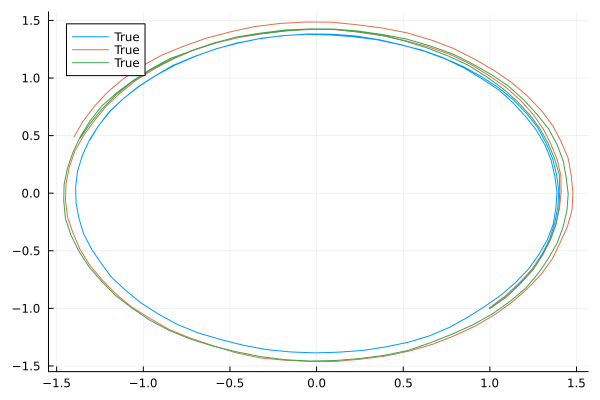

In [35]:
# plot(E_z[3, :, 1], E_z[3, :, 2], label="Smooth", legend=:topleft)
plot(x[1, :, 1], x[1, :, 2], label="True", legend=:topleft)
plot!(x[2, :, 1], x[2, :, 2], label="True", legend=:topleft)
plot!(x[3, :, 1], x[3, :, 2], label="True", legend=:topleft)


In [26]:
@time E_z, E_zz, E_zz_prev, x_smooth, p_smooth = SSM.E_Step(plds, y_array)

  0.019602 seconds (19.25 k allocations: 1.561 MiB)


([0.20709850826515694 1.531768958712076 1.2702420726238886; 1.436795859851566 1.978081765029239 2.1077682807152476; 0.5130204995643982 0.39088717193542477 0.05026593562705378;;; -0.6512292912537166 -0.5938393630198808 0.28089906757518357; -0.0845572541518394 0.010980939034209929 0.5668809327537808; 0.10195655870670703 -0.03269081231298401 -0.03967952740769964], [0.2563835135305298 2.456129829580229 1.757370740957948; 2.1659783260414427 3.9880908587190773 4.518152491777998; 0.4414791344007212 0.369098561774297 0.33432392435921976;;; -0.2103498007486575 -1.0321931995676372 0.16482456761993725; -0.1949817732085529 -0.07220892526579079 1.0697533358025184; -0.03980357589843901 -0.18345030602427714 -0.2944548306384653;;;; -0.21034980074865753 -1.0321931995676372 0.1648245676199372; -0.19498177320855292 -0.07220892526579081 1.0697533358025184; -0.03980357589843904 -0.1834503060242771 -0.2944548306384651;;; 1.0572616240706736 1.1913483645838006 1.1665145882101653; 0.5233853351232802 0.62326241

In [ ]:
H, main, super, sub = SSM.Hessian()

In [24]:

init_mean_est = (E_z[1, 1, :] + E_z[2, 1, :] + E_z[3, 1, :]) / 3

est_1 = E_zz[1, 1, :, :] - init_mean_est * init_mean_est' #- E_z[1, 1, :] * E_z[1, 1, :]'
est_2 = E_zz[2, 1, :, :] - init_mean_est * init_mean_est' #- E_z[2, 1, :] * E_z[2, 1, :]'
est_3 = E_zz[3, 1, :, :] - init_mean_est * init_mean_est' #- E_z[3, 1, :] * E_z[3, 1, :]'

final_est = (est_1 + est_2 + est_3) / 3

2×2 Matrix{Float64}:
  0.246564   -0.0599246
 -0.0599246   0.644223

In [18]:
# optimization based approach
obj = sqrt_p0 -> -SSM.Q_initial_obs(init_mean_est, sqrt_p0, E_z, E_zz)

res = optimize(obj, plds.p0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     2.059375e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.24e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.54e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.51e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.34e-10 ≰ 0.0e+00
    |g(x)|                 = 3.79e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    23
    ∇f(x) calls:   23


In [21]:
res.minimizer * res.minimizer'

2×2 Matrix{Float64}:
  0.246564   -0.0599246
 -0.0599246   0.644223

In [15]:
final_est

2×2 Matrix{Float64}:
  0.18361    -0.0851161
 -0.0851161   0.623929

In [4]:
using Profile
using ProfileView

In [13]:
ProfileView.@profview SSM.fit!(plds, y_array, 1)

Succesfully smoothed at iteration 1
Maximum iterations reached without convergence.


Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile  -  16:35:47", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip

In [25]:
SSM.smooth(plds, y_array)

ArgumentError: ArgumentError: matrix contains Infs or NaNs

In [32]:
plds.A

2×2 Matrix{Float64}:
 0.673648  -0.0403819
 0.307145   0.972538

In [22]:
plds.C

3×2 Matrix{Float64}:
 143.725  112.912
 143.755  112.939
 143.489  112.698

In [15]:
maximum(p_sm)

9.970479765092223

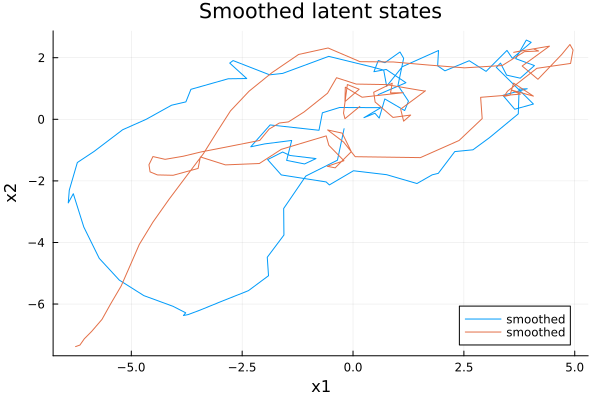

In [13]:
plot(x_sm[1, :, :], x_sm[2, :, :], label="smoothed", xlabel="x1", ylabel="x2", title="Smoothed latent states")

In [7]:
SSM.fit!(plds, y_array, 2)

Succesfully smmothed at iteration 1


SingularException: SingularException(2)

In [7]:
plds.C

3×2 Matrix{Float64}:
 1.20545  0.98404
 1.35706  0.929379
 1.1095   0.245278

In [12]:
# define a function that wraps the loglikelihood function
function likelihood_wrapper(vec_x::Vector{<:Real})
    # Calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct from
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the loglikelihood
    return -SSM.logposterior(x, plds, y)
end

# define a function that wraps the gradient of the loglikelihood function
function gradient!(G::Vector{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the gradient
    G .= vec(permutedims(-SSM.Gradient(x, plds, y)))
end

# define a function that wraps the hessian of the loglikelihood function
function hessian!(H::Matrix{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the hessian
    hess, _, _, _ = SSM.Hessian(x, plds, y)
    H .= -hess
end

# init guess
x0 = zeros(200)
y = y_array[3, :, :]

res = optimize(likelihood_wrapper, gradient!, hessian!, x0)

 * Status: success

 * Candidate solution
    Final objective value:     -4.974156e+03

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.19e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.49e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.28e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 5.36e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    24
    ∇f(x) calls:   24
    ∇²f(x) calls:  7


In [7]:
x_new = SSM.interleave_reshape(res.minimizer, 100, 2)

100×2 Matrix{Float64}:
 0.818803  -0.505183
 1.0888    -0.869092
 1.00775   -1.67825
 1.32243   -2.1677
 1.6667    -2.26547
 2.28964   -2.61679
 2.77547   -2.41452
 2.52389   -2.22462
 2.77324   -2.00848
 2.54326   -2.05983
 ⋮         
 2.2561    -1.859
 1.2725    -1.46888
 1.32627   -1.07616
 2.26908   -1.28299
 1.76964   -1.22193
 2.20769   -1.44578
 2.68592   -1.19145
 2.72206   -1.67097
 3.18873   -1.6681

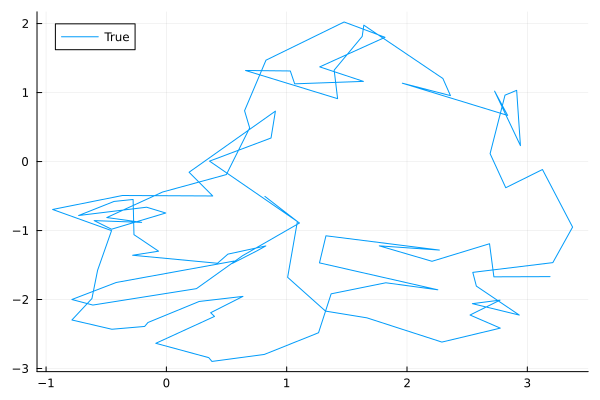

In [15]:
plot(x_new[:, 1], x_new[:, 2], label="True")

In [10]:
grad = SSM.Gradient(x_new, plds, y)

maximum(grad)

8.311129562343922e-13

In [1]:


df = CSV.read("/Users/ryansenne/Downloads/fit_all_4_rest.csv", DataFrame);

In [37]:
function parse_to_matrix(s::String)
    # Remove outer brackets and split by semicolon
    rows = split(strip(s, ['[', ']']), ';')
    
    # Parse each row
    parsed_rows = map(rows) do row
        # Remove brackets from each row and split by comma
        elements = split(strip(row, ['[', ']']), ',')
        
        # Parse each element, handling special cases
        map(elements) do elem
            elem = strip(elem)
            if elem == "-Inf"
                return -Inf
            elseif elem == "Inf" || elem == "+Inf"
                return Inf
            else
                return parse(Float64, elem)
            end
        end
    end
    
    # Convert to matrix
    return reduce(hcat, parsed_rows)'
end
# Apply the parsing function to the 'y' column
df.γ = parse_to_matrix.(df.γ)

ArgumentError: ArgumentError: cannot parse ".346177957733744 0.0 -710.4562785852722 -Inf" as Float64

In [44]:
"""
    mutable struct PoissonPCA end
A probabilsitic (PCA?) model for Poisson distributed data.
# Fields
- `C::Matrix{<:Real}`: The loading matrix
- `log_d::Vector{<:Real}`: The log bias vector
- `latent_dim::Int64`: The latent dimensionality
- `obs_dim::Int64`: The observation dimensionality
"""
mutable struct PoissonPCA 
    C::Matrix{<:Real}
    log_d::Vector{<:Real}
    latent_dim::Int64
    obs_dim::Int64
end

"""
    PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), d::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
Constructor for PoissonPCA
# Arguments
- `C::Matrix{<:Real}`: The loading matrix
- `log_d::Vector{<:Real}`: The log bias vector
- `latent_dim::Int64`: The latent dimensionality
- `obs_dim::Int64`: The observation dimensionality
"""
function PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), log_d::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
    # initialize C
    if isempty(C)
        C = randn(obs_dim, latent_dim)
    end
    # initialize b
    if isempty(log_d)
        log_d = rand(obs_dim)
    end
    return PoissonPCA(C, log_d, latent_dim, obs_dim)
end

"""
    gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    
Calculate the gradient of the Poisson PCA model. Designed to be passed to LBFGS in Optim.jl.
# Arguments
- `grad::Vector{<:Real}`: The gradient vector
- `x::Vector{<:Real}`: The latent variables
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    T, n = size(y)
    x_mat = reshape(x, T, model.latent_dim)
    d = exp.(model.log_d)
    
    gradient = zeros(T, model.latent_dim)
    for t in 1:T
        λt = exp.(model.C * x_mat[t, :] .+ d)
        gradient[t, :] = model.C' * (y[t, :] - λt)
    end
    
    grad .= -vec(gradient)
end

"""
    hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})

Calculate the Hessian of the Poisson PCA model. Designed to be passed to LBFGS in Optim.jl.

# Arguments
- `hess::Matrix{<:Real}`: The Hessian matrix
- `x::Vector{<:Real}`: The latent variables
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    T, n = size(y)
    k = model.latent_dim
    x_mat = reshape(x, T, k)
    d = exp.(model.log_d)
    
    # Initialize Hessian
    H = zeros(T * k, T * k)
    
    for t in 1:T
        λt = exp.(model.C * x_mat[t, :] .+ d)
        H_block = -model.C' * Diagonal(λt) * model.C
        
        # Place the block in the correct position in the Hessian
        start_idx = (t - 1) * k + 1
        end_idx = t * k
        H[start_idx:end_idx, start_idx:end_idx] = H_block
    end
    
    hess .= -H  # Negative because we're working with log-likelihood
end

"""
    loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
Calculate the log-likelihood of the Poisson PCA model.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `x::Matrix{<:Real}`: The latent variables
- `y::Matrix{<:Real}`: The observed data
"""
function loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    d = exp.(model.log_d)
    T = size(y, 1)
    ll = 0.0
    for t in 1:T
        ll += sum(y[t, :] .* (model.C * x[t, :] + model.b)) - sum(exp.(model.C * x[t, :] + d))
    end
    return ll
end

"""
    E_Step(model::PoissonPCA, y::Matrix{<:Real})
E-Step for Poisson PCA. Computes a MAP estimate of the latent variables by optimiizing the log-likelihood w.r.t. the latent variables.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function E_Step(model::PoissonPCA, y::Matrix{<:Real})
    # create an objective function to minimize
    function obj(x)
        x = reshape(x, size(y, 1), model.latent_dim)
        return -loglikelihood_(model, x, y)
    end
    # create a wrapper for gradient
    function grad!(g, x)
        gradient!(g, x, model, y)
    end
    # optimize the objective function
    res = optimize(obj, grad!, vec(rand(size(y, 1), model.latent_dim)), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    return reshape(res.minimizer, size(y, 1), model.latent_dim)
end

function Q_function(model::PoissonPCA, E_z::Matrix{<:Real}, P_sm::Matrix{<:Real}, y::Matrix{<:Real})
    # Calculate the Q function
    Q = 0.0
    for t in axes(y, 1)
        # compute the linear term
        term_1 = 

"""
    M_Step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
M-Step for Poisson PCA
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `x::Matrix{<:Real}`: The latent variables
- `y::Matrix{<:Real}`: The observed data
"""
function M_Step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    # define objective function to minimize
    function obj(params)
        C = reshape(params[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
        b = params[model.latent_dim * model.obs_dim + 1:end]
        return -loglikelihood_(PoissonPCA(C, b, model.latent_dim, model.obs_dim), x, y)
    end
    # optimize the objective function
    res = optimize(obj, vcat(reshape(model.C, model.latent_dim * model.obs_dim), model.b), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    model.C = reshape(res.minimizer[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
    model.b = res.minimizer[model.latent_dim * model.obs_dim + 1:end]
end

"""
    fit!(model::PoissonPCA, y::Matrix{<:Real}, max_iters::Int=100, tol=1e-6)
Fit the Poisson PCA model to the data.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
- `max_iters::Int=100`: The maximum number of iterations
- `tol::Float64=1e-6`: The tolerance for convergence
"""
function fit!(model::PoissonPCA, y::Matrix{<:Real}, max_iters::Int=100, tol=1e-6)
    # set up first ll
    ll_prev = -Inf
    # Go!
    prog = Progress(max_iters; desc="Fitting Poisson PCA...")
    for i in 1:max_iters
        x = E_Step(model, y)
        M_Step!(model, x, y)
        #println("Log-Likelihood at iter $i: $(loglikelihood_(model, x, y))")
        next!(prog)
        # check for convergence
        ll = loglikelihood_(model, x, y)
        if abs(ll - ll_prev) < tol
            #println("Converged after $i iterations")
            finish!(prog)
            break
        end
    end
end

ErrorException: syntax: extra token "the" after end of expression

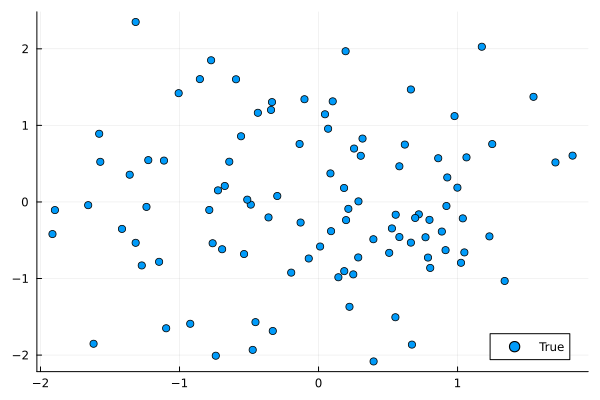

In [66]:
function simulate_poisson_pca(n::Int, T::Int, k::Int; seed=123)
    Random.seed!(seed)
    
    # Generate model parameters
    C = randn(n, k)
    log_d = randn(n)
    d = exp.(log_d)
    
    # Generate latent variables X
    X = randn(T, k)
    
    # Generate observed data Y
    Y = zeros(Int, T, n)
    for t in 1:T
        λ = exp.(C * X[t, :] .+ d)
        Y[t, :] = rand.(Poisson.(λ))
    end
    
    model = PoissonPCA(;C=C, log_d=log_d, latent_dim=k, obs_dim=n)
    return model, X, Y
end

# Simulate data
n, T, k = 10, 100, 2
model, true_X, Y = simulate_poisson_pca(n, T, k)

scatter(true_X[:, 1], true_X[:, 2], label="True")

In [68]:
gradient!(zeros(200), vec(true_X), model, convert(Matrix{Float64}, Y))

200-element Vector{Float64}:
  431.83214174502064
 2018.0867636231706
  324.47782846560585
 1139.6368803393561
 -844.6397883879254
  175.49291408747376
 -164.71013252134435
 -136.7223825417459
 -333.1000781666953
   12.139601675153244
    ⋮
 -622.3960917880759
  425.0499805971631
 1283.664881253615
 -272.571718139312
  -40.885875682812184
  831.5239567029639
   61.01892168377526
  -27.072299299004953
 -866.2902068493422